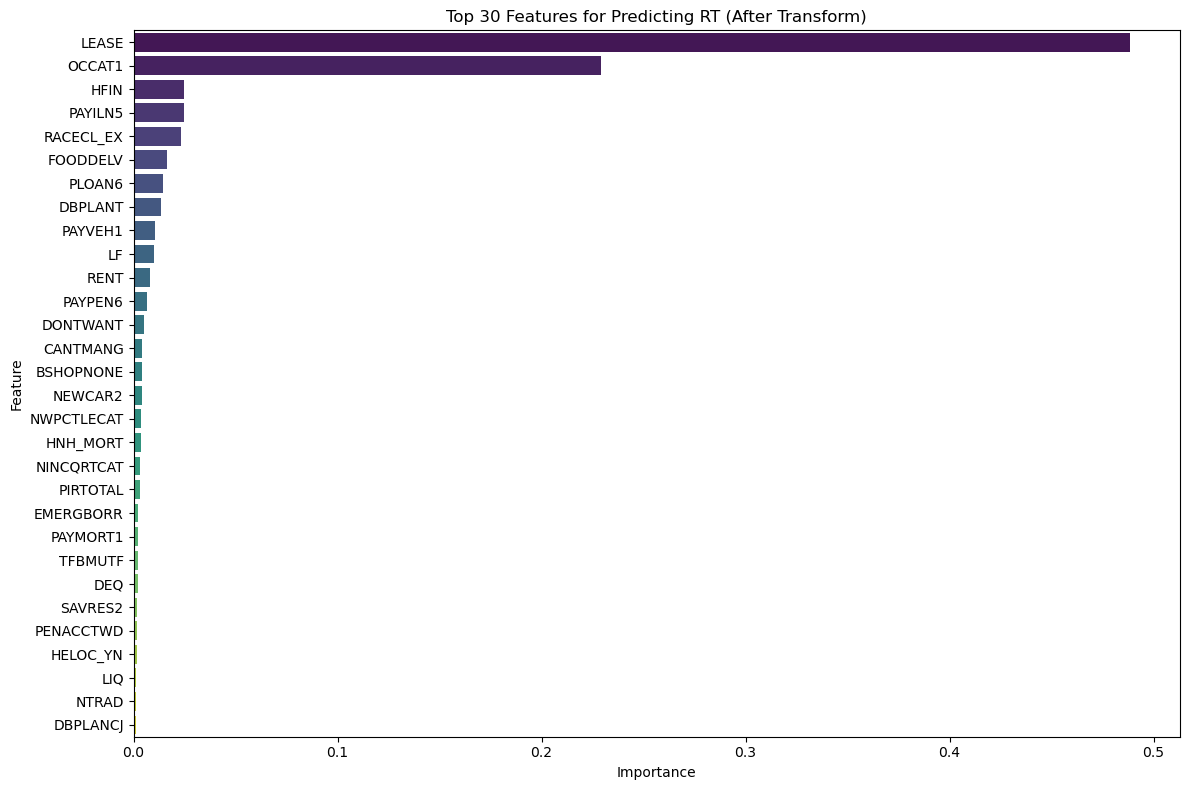

Top 30 Features (Descending Order):
1. LEASE: 0.4885
2. OCCAT1: 0.2290
3. HFIN: 0.0249
4. PAYILN5: 0.0247
5. RACECL_EX: 0.0234
6. FOODDELV: 0.0163
7. PLOAN6: 0.0144
8. DBPLANT: 0.0135
9. PAYVEH1: 0.0105
10. LF: 0.0099
11. RENT: 0.0081
12. PAYPEN6: 0.0067
13. DONTWANT: 0.0052
14. CANTMANG: 0.0042
15. BSHOPNONE: 0.0042
16. NEWCAR2: 0.0039
17. NWPCTLECAT: 0.0037
18. HNH_MORT: 0.0035
19. NINCQRTCAT: 0.0033
20. PIRTOTAL: 0.0031
21. EMERGBORR: 0.0024
22. PAYMORT1: 0.0023
23. TFBMUTF: 0.0021
24. DEQ: 0.0020
25. SAVRES2: 0.0019
26. PENACCTWD: 0.0017
27. HELOC_YN: 0.0017
28. LIQ: 0.0013
29. NTRAD: 0.0012
30. DBPLANCJ: 0.0012

Preview after transformations and filtering:
    AGE  EDCL  MARRIED  KIDS  OCCAT1     INCOME  YESFINRISK      ASSET  \
0    70     3        2     2       3  10.566298           0  13.771663   
1    70     3        2     2       3  10.552272           0  13.880643   
2    70     3        2     2       3  10.494116           0  13.771768   
3    70     3        2     2      

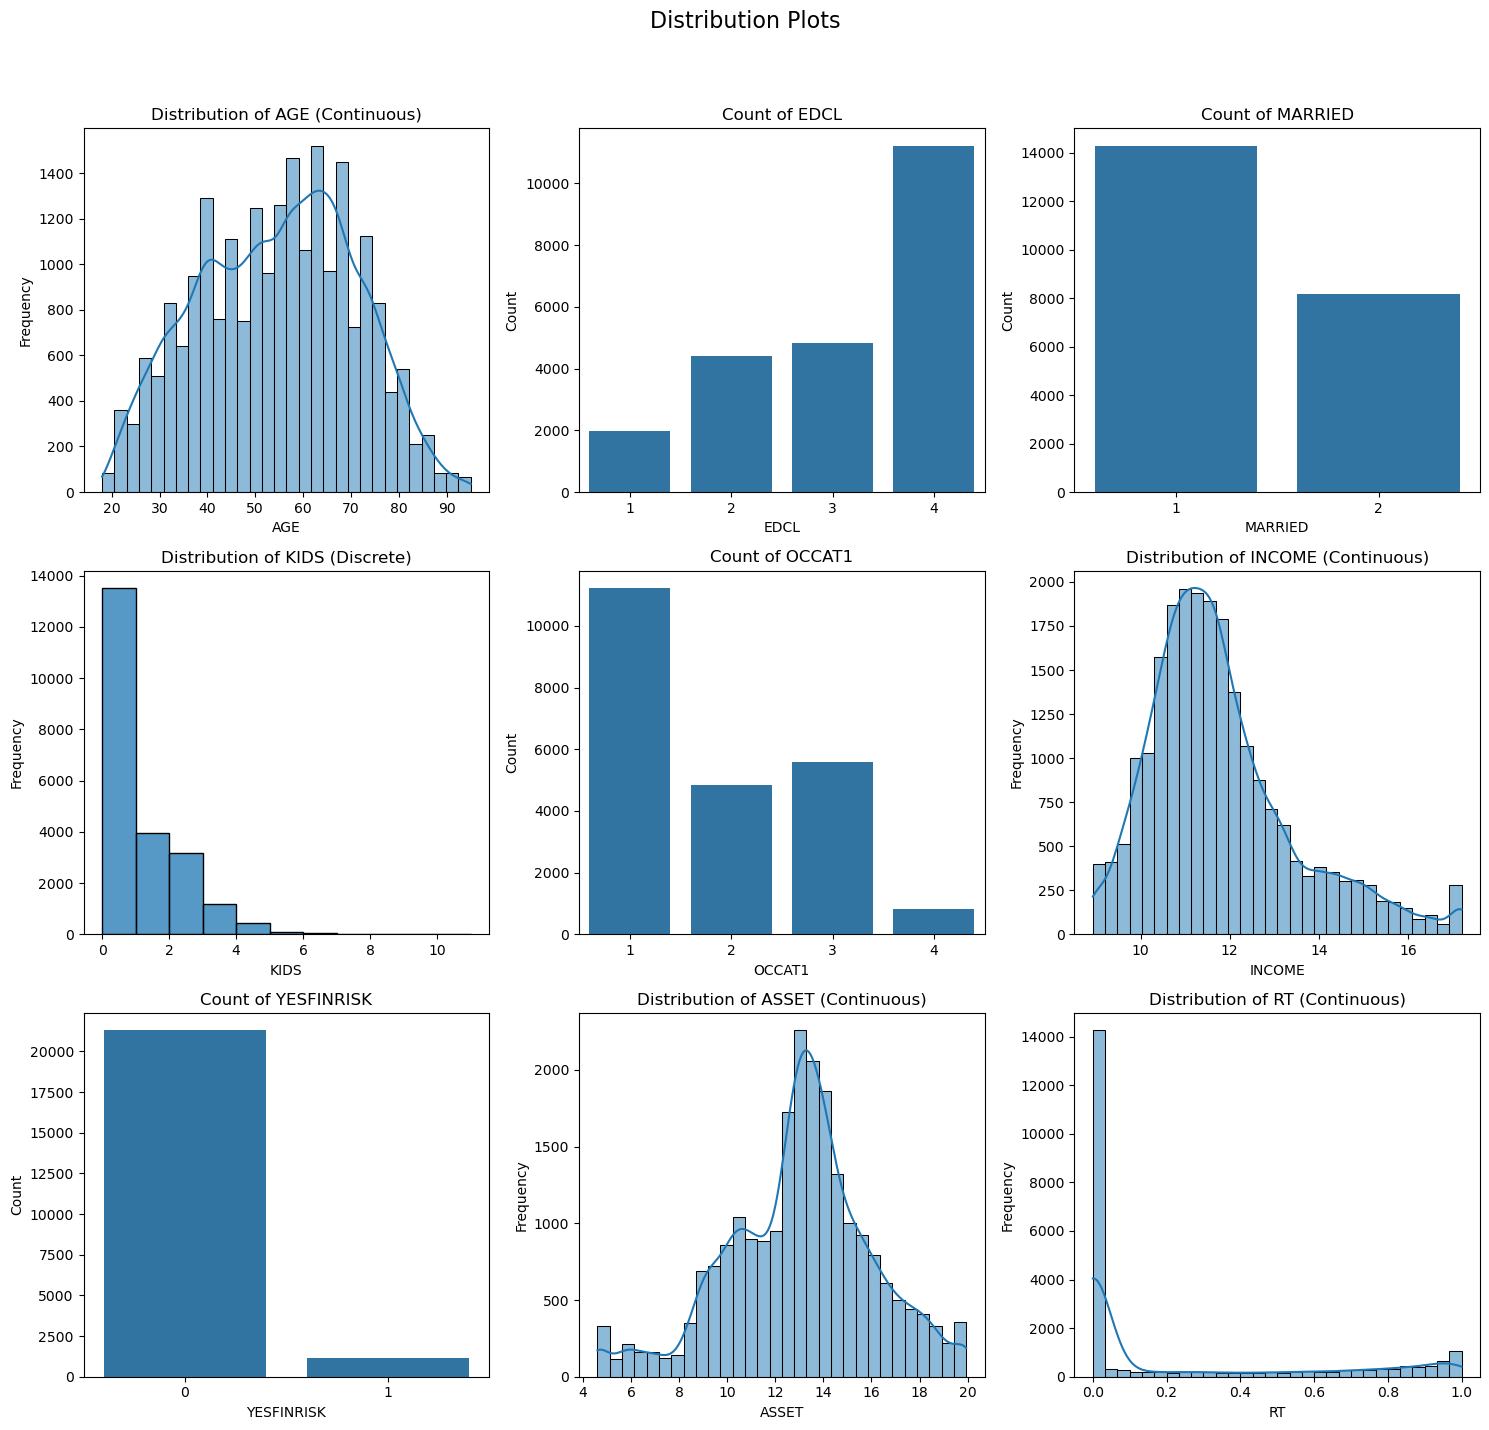

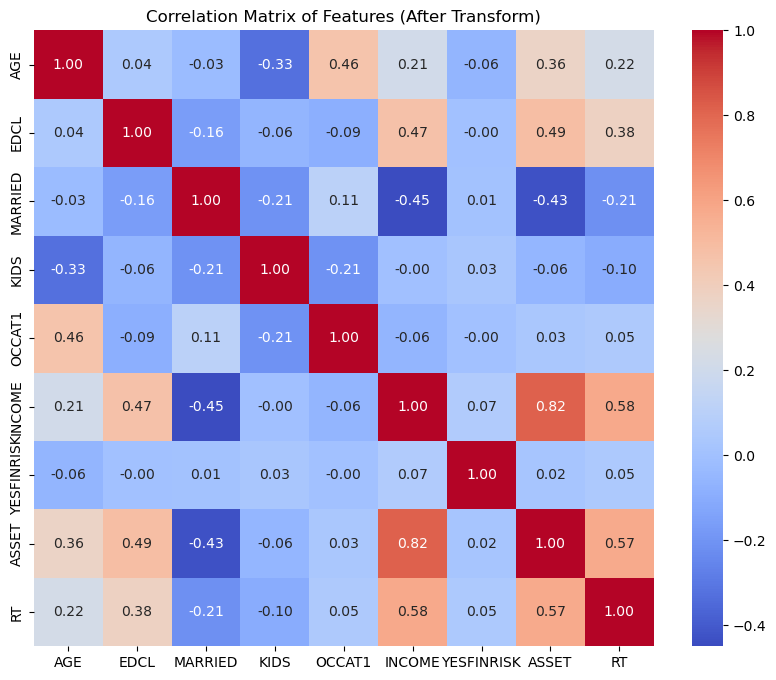


First 10 columns after one-hot encoding:
       AGE  KIDS     INCOME      ASSET        RT  EDCL_2  EDCL_3  EDCL_4  \
0       70     2  10.566298  13.771663  0.000000   False    True   False   
1       70     2  10.552272  13.880643  0.000000   False    True   False   
2       70     2  10.494116  13.771768  0.000000   False    True   False   
3       70     2  10.419547  13.627493  0.000000   False    True   False   
4       70     2  10.479033  13.623866  0.000000   False    True   False   
...    ...   ...        ...        ...       ...     ...     ...     ...   
22965   56     0  10.936804  12.571341  0.873786   False    True   False   
22966   56     0  11.175215  12.574320  0.894040   False    True   False   
22967   56     0  11.112695  12.571098  0.883797   False    True   False   
22968   56     0  11.262226  12.572554  0.826953   False    True   False   
22969   56     0  11.010912  12.575358  0.851735   False    True   False   

       MARRIED_2  OCCAT1_2  
0           True

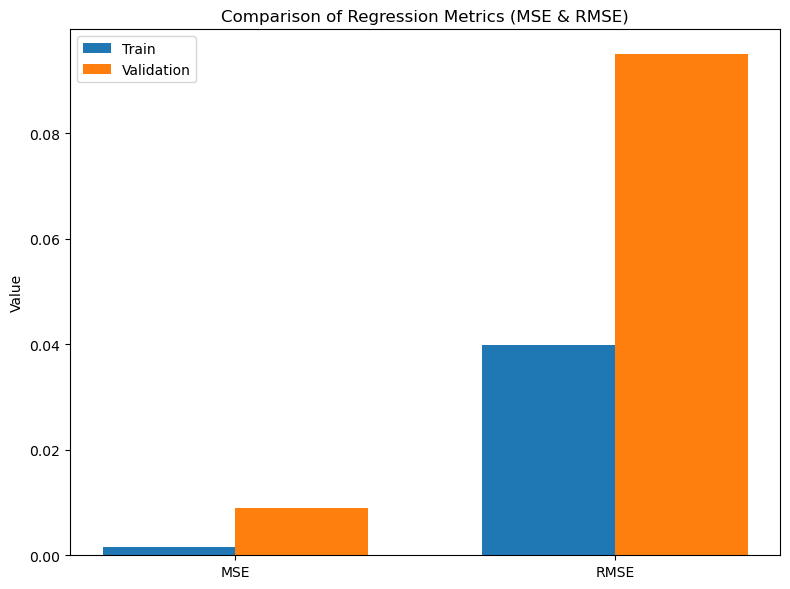

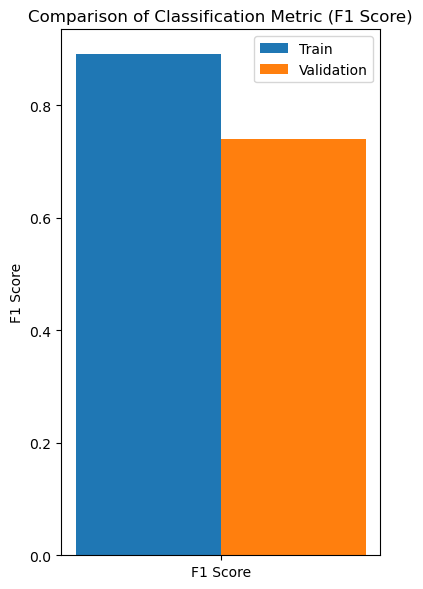


Feature Importances:
ASSET           0.327333
INCOME          0.269939
AGE             0.165003
EDCL_4          0.098350
KIDS            0.047835
MARRIED_2       0.023927
OCCAT1_2        0.019767
OCCAT1_3        0.016791
YESFINRISK_1    0.012086
EDCL_2          0.006917
EDCL_3          0.006677
OCCAT1_4        0.005375
dtype: float64


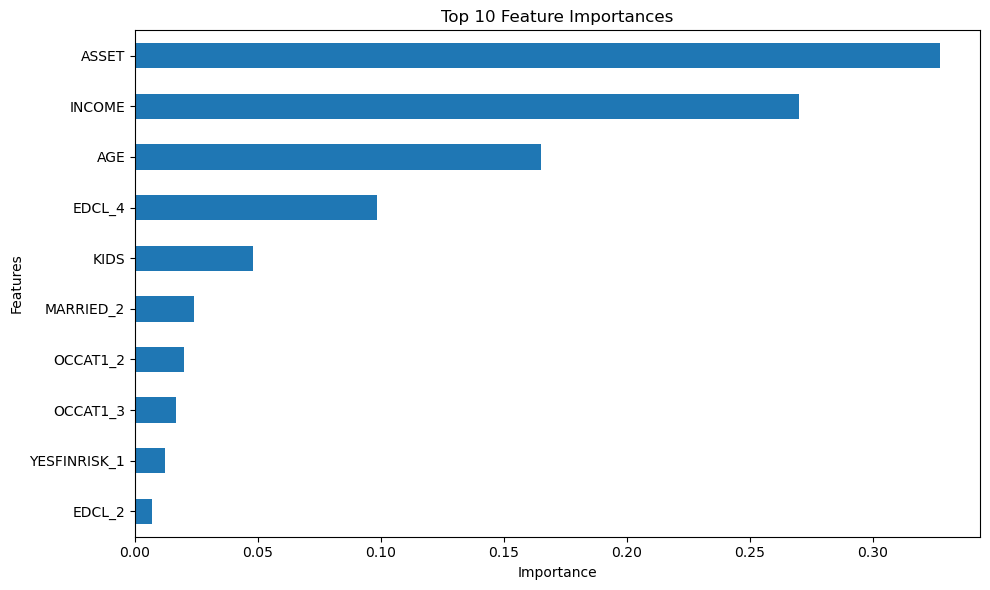

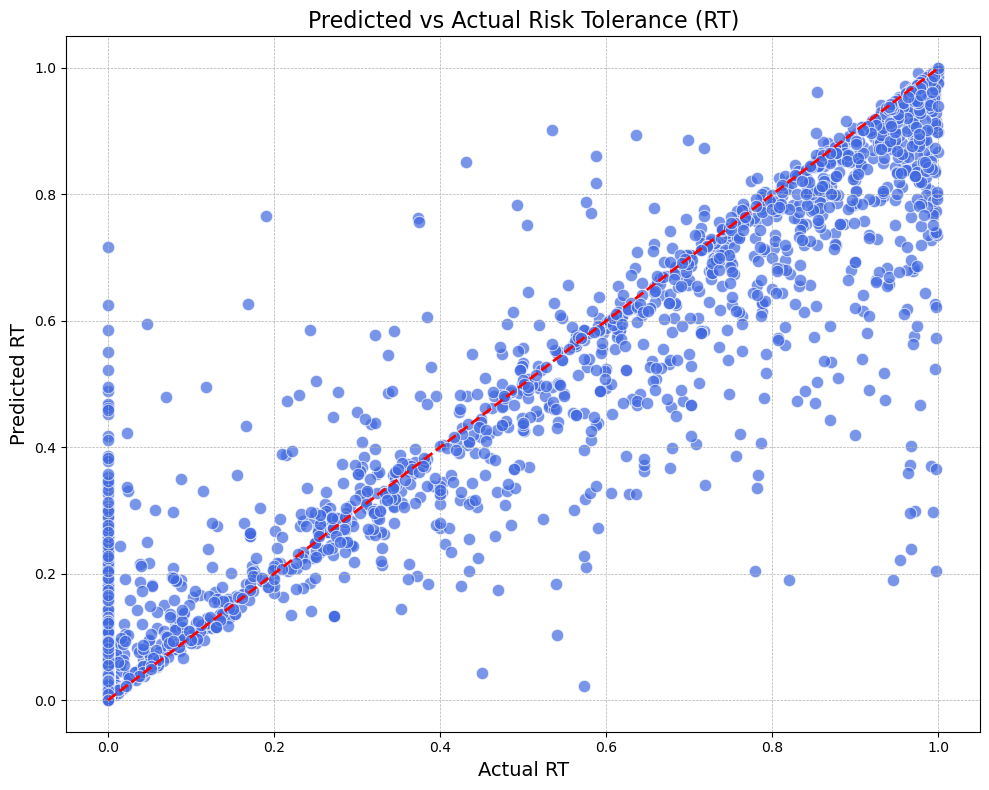

Model saved to 'model.pkl'


In [ ]:
# Installing necessary packages
!pip install openpyxl
!pip install tensorflow
!pip install scikeras
!pip install xgboost
!pip install lightgbm
!pip install catboost

# Imports from scikit-learn and other libraries
import warnings
import numpy as np
import pandas as pd
from pickle import dump, load
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor,
    AdaBoostRegressor
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    KFold
)
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Suppress warnings
warnings.filterwarnings('ignore')

# 1. Data Loading and Basic Cleaning
# Load dataset
dataset = pd.read_excel('SCFP2022.xlsx')

# Calculate Risk tolerance for 2022
dataset['RiskFree'] = dataset['LIQ'] + dataset['CDS'] + dataset['SAVBND'] + dataset['CASHLI']
dataset['Risky'] = dataset['NMMF'] + dataset['STOCKS'] + dataset['BOND']
dataset['RT'] = dataset['Risky'] / (dataset['Risky'] + dataset['RiskFree'])

# Remove invalid data
dataset = dataset.dropna(axis=0)
dataset = dataset[~dataset.isin([np.nan, np.inf, -np.inf]).any(axis=1)]

# 2. Outlier Capping & Log Transformation for INCOME and ASSET
def cap_outliers_and_log_transform(df, col, lower_q=0.01, upper_q=0.99):
    df = df[df[col] > 0]
    
    lower_val = df[col].quantile(lower_q)
    upper_val = df[col].quantile(upper_q)
    df[col] = np.clip(df[col], lower_val, upper_val)
    
    df[col] = np.log(df[col])
    return df

cols_to_transform = ['INCOME', 'ASSET']
for col in cols_to_transform:
    dataset = cap_outliers_and_log_transform(dataset, col)

# 3. Feature Selection
# For feature importance demonstration (before one-hot encoding)
X_plot = dataset.drop(columns=['RT'])
Y_plot = dataset['RT']

seed = 42
X_train_tmp, X_validation_tmp, Y_train_tmp, Y_validation_tmp = train_test_split(
    X_plot, Y_plot, test_size=0.2, random_state=seed
)

model_tmp = ExtraTreesRegressor(random_state=seed)
model_tmp.fit(X_train_tmp, Y_train_tmp)

importances_tmp = model_tmp.feature_importances_
indices_tmp = np.argsort(importances_tmp)[::-1]
feature_names_tmp = X_plot.columns[indices_tmp]

top_n = 30
top_indices_tmp = indices_tmp[:top_n]
top_feature_names_tmp = feature_names_tmp[top_indices_tmp]
top_importances_tmp = importances_tmp[top_indices_tmp]

plt.figure(figsize=(12, 8))
sns.barplot(x=top_importances_tmp, y=top_feature_names_tmp, palette="viridis")
plt.title(f"Top {top_n} Features for Predicting RT (After Transform)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

print(f"Top {top_n} Features (Descending Order):")
for i, (feature, importance) in enumerate(zip(top_feature_names_tmp, top_importances_tmp)):
    print(f"{i+1}. {feature}: {importance:.4f}")

keep_list = ['AGE', 'EDCL', 'MARRIED', 'KIDS', 'OCCAT1', 'INCOME', 'YESFINRISK', 'ASSET', 'RT']
dataset = dataset[keep_list]

print("\nPreview after transformations and filtering:")
print(dataset.head(20))

# 4. Data Presentation (Plots) Re-check
import math

categorical_vars = ['EDCL', 'MARRIED', 'OCCAT1', 'YESFINRISK']
discrete_numeric_vars = ['KIDS']
continuous_vars = ['AGE', 'INCOME', 'ASSET', 'RT']

num_columns = len(dataset.columns)
grid_size = 3
num_plots = math.ceil(num_columns / (grid_size * grid_size))

for plot_idx in range(num_plots):
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig.suptitle('Distribution Plots', fontsize=16)
    
    cols_for_this_plot = dataset.columns[plot_idx * grid_size**2 : (plot_idx + 1) * grid_size**2]
    for idx, column in enumerate(cols_for_this_plot):
        row, col = divmod(idx, grid_size)
        if column in categorical_vars:
            sns.countplot(x=column, data=dataset, ax=axes[row, col])
            axes[row, col].set_title(f'Count of {column}')
            axes[row, col].set_xlabel(column)
            axes[row, col].set_ylabel('Count')
        elif column in discrete_numeric_vars:
            sns.histplot(data=dataset, x=column, kde=False,
                         bins=range(int(dataset[column].min()),
                                    int(dataset[column].max())+2),
                         ax=axes[row, col])
            axes[row, col].set_title(f'Distribution of {column} (Discrete)')
            axes[row, col].set_xlabel(column)
            axes[row, col].set_ylabel('Frequency')
        else:
            sns.histplot(data=dataset, x=column, kde=True, bins=30, ax=axes[row, col])
            axes[row, col].set_title(f'Distribution of {column} (Continuous)')
            axes[row, col].set_xlabel(column)
            axes[row, col].set_ylabel('Frequency')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Correlation Matrix
corr_matrix = dataset.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Features (After Transform)")
plt.show()

# 5. One-Hot Encoding for Categorical Variables
dataset[categorical_vars] = dataset[categorical_vars].astype('category')
dataset_encoded = pd.get_dummies(dataset, columns=categorical_vars, drop_first=True)

# Print first 10 columns after one-hot encoding for inspection
print("\nFirst 10 columns after one-hot encoding:")
print(dataset_encoded.iloc[:, :10])

# 6. Modeling and Evaluation
Y = dataset_encoded['RT']
X = dataset_encoded.drop(columns=['RT'])

validation_size = 0.2
seed = 42
X_train, X_validation, Y_train, Y_validation = train_test_split(
    X, Y, test_size=validation_size, random_state=seed
)

num_folds = 10
scoring = 'r2'

models = []
models.append(('ETR', ExtraTreesRegressor()))

from sklearn.model_selection import KFold, cross_val_score

results = []
names = []
print("Model Evaluation Results (using R² scoring):")
for name, mdl in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(mdl, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: Mean R² = {cv_results.mean():.4f}, Std Dev = {cv_results.std():.4f}")

# Hyperparameter tuning using RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

model = ExtraTreesRegressor(random_state=seed)
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=20,
    scoring=scoring,
    cv=kfold,
    random_state=seed,
    n_jobs=-1,
    verbose=1
)
random_result = random_search.fit(X_train, Y_train)
print("\nBest: %f using %s" % (random_result.best_score_, random_result.best_params_))
for mean, stdev, param in zip(random_result.cv_results_['mean_test_score'],
                              random_result.cv_results_['std_test_score'],
                              random_result.cv_results_['params']):
    print("%f (%f) with: %r" % (mean, stdev, param))

model = ExtraTreesRegressor(
    n_estimators=random_result.best_params_['n_estimators'],
    max_depth=random_result.best_params_['max_depth'],
    min_samples_split=random_result.best_params_['min_samples_split'],
    min_samples_leaf=random_result.best_params_['min_samples_leaf'],
    bootstrap=random_result.best_params_['bootstrap'],
    random_state=seed
)
model.fit(X_train, Y_train)

# Evaluation on Training Data
predictions_train = model.predict(X_train)
print("\nTraining Metrics:")
r2_train = r2_score(Y_train, predictions_train)
mse_train = mean_squared_error(Y_train, predictions_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(Y_train, predictions_train)
print("R²:", r2_train)
print("MSE:", mse_train)
print("RMSE:", rmse_train)
print("MAE:", mae_train)

# Evaluation on Validation Data
predictions = model.predict(X_validation)
print("\nValidation Metrics:")
mse_val = mean_squared_error(Y_validation, predictions)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(Y_validation, predictions)
r2_val = r2_score(Y_validation, predictions)
print("MSE:", mse_val)
print("RMSE:", rmse_val)
print("MAE:", mae_val)
print("R²:", r2_val)

# Classification Evaluation using F1 Score
num_levels = 5
global_min = Y.min()
global_max = Y.max()
bins = np.linspace(global_min, global_max, num_levels+1)

Y_train_class = pd.cut(Y_train, bins=bins, labels=False, include_lowest=True)
predictions_train_class = pd.cut(predictions_train, bins=bins, labels=False, include_lowest=True)
f1_train = f1_score(Y_train_class, predictions_train_class, average='macro')

Y_val_class = pd.cut(Y_validation, bins=bins, labels=False, include_lowest=True)
predictions_val_class = pd.cut(predictions, bins=bins, labels=False, include_lowest=True)
f1_val = f1_score(Y_val_class, predictions_val_class, average='macro')

print("\nClassification (F1 Score) Evaluation (after discretizing RT into 5 levels):")
print("Training F1 Score:", f1_train)
print("Validation F1 Score:", f1_val)

# Visualizing Regression Metrics (MSE & RMSE)
metrics = ['MSE', 'RMSE']
train_values = [mse_train, rmse_train]
val_values = [mse_val, rmse_val]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,6))
plt.bar(x - width/2, train_values, width, label='Train')
plt.bar(x + width/2, val_values, width, label='Validation')
plt.xticks(x, metrics)
plt.ylabel('Value')
plt.title('Comparison of Regression Metrics (MSE & RMSE)')
plt.legend()
plt.tight_layout()
plt.show()

# Visualizing Classification Metric (F1 Score)
metrics_f1 = ['F1 Score']
train_f1_vals = [f1_train]
val_f1_vals = [f1_val]

x = np.arange(len(metrics_f1))
width = 0.35

plt.figure(figsize=(4,6))
plt.bar(x - width/2, train_f1_vals, width, label='Train')
plt.bar(x + width/2, val_f1_vals, width, label='Validation')
plt.xticks(x, metrics_f1)
plt.ylabel('F1 Score')
plt.title('Comparison of Classification Metric (F1 Score)')
plt.legend()
plt.tight_layout()
plt.show()

# Feature Importance
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
print("\nFeature Importances:")
print(feat_importances.sort_values(ascending=False))
plt.figure(figsize=(10, 6))
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Predictions vs Actuals Plot
plt.figure(figsize=(10,8))
sns.scatterplot(x=Y_validation, y=predictions, color='royalblue', alpha=0.7, s=80)
plt.plot([Y_validation.min(), Y_validation.max()], [Y_validation.min(), Y_validation.max()], color='red', lw=2, ls='--')
plt.xlabel("Actual RT", fontsize=14)
plt.ylabel("Predicted RT", fontsize=14)
plt.title("Predicted vs Actual Risk Tolerance (RT)", fontsize=16)
plt.grid(True, which='both', ls='--', lw=0.5)
plt.tight_layout()
plt.show()

# Save the Model
import pickle
model_filename = 'model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)
print("Model saved to 'model.pkl'")